In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup


import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification


# Helper Function

In [ ]:
import re
def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    return text


def remove_year(string):
    return re.sub(r'\s20\d{2}(\s|\-\d{2})?', ' ', string)

# Import Data

In [ ]:

dataset = pd.read_csv('BIL Launchpad Case studies - Sheet1.csv')

"""
Cleaning the data:
- only include columns we will use: 'Project Name', 'Project Description', 'Applicants', 'opportunitytitle', 'description'
- drop column with missing information
- currently, the grant opportunities include years, i will omit this from their title to group recurring grants together
"""
dataset = dataset[['Project Name', 'Project Description', 'Applicants', 'opportunitytitle', 'description']]
clean_dataset = dataset.dropna()
print(len(clean_dataset['opportunitytitle'].unique()))
# print(dataset['opportunitytitle'].unique())
clean_dataset['description'] = clean_dataset['description'].apply(remove_numbers)
clean_dataset['opportunitytitle'] = clean_dataset['opportunitytitle'].apply(remove_numbers)

print(len(clean_dataset['opportunitytitle'].unique()))
# print(dataset['opportunitytitle'].unique())

79
55


<ipython-input-3-7d99546f415f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['description'] = clean_dataset['description'].apply(remove_numbers)
<ipython-input-3-7d99546f415f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['opportunitytitle'] = clean_dataset['opportunitytitle'].apply(remove_numbers)


# Experiment 1: Classification of project <> grant name (multi-class text classification) (ignore description of program)

In [ ]:
# Create new dataset of project + project name and grant title
simple_df = clean_dataset[['Project Name', 'Project Description', 'Applicants', 'opportunitytitle']]
simple_df['project_profile'] =  simple_df['Applicants'] + ': ' + simple_df['Project Description'] + ' ' + simple_df['Project Name']
simple_df = simple_df[['project_profile','opportunitytitle'] ]
possible_grants = simple_df['opportunitytitle'].unique()

#substitute label with number instead
label_dict = {}
for index, possible_label in enumerate(possible_grants):
    label_dict[possible_label] = index

simple_df['label'] = simple_df['opportunitytitle'].replace(label_dict)
simple_df


,project_profile,opportunitytitle,label
0,Fairbanks International Airport: This award fu...,FY Notice of Funding Opportunity: Bipartisan ...,0
1,Ted Stevens Anchorage International Airport: T...,FY Notice of Funding Opportunity: Bipartisan ...,0
2,Ted Stevens Anchorage International Airport: T...,FY Notice of Funding Opportunity: Bipartisan ...,0
3,Phoenix Sky Harbor International Airport: This...,FY Notice of Funding Opportunity: Bipartisan ...,0
4,Yuma International Airport: This award funds u...,FY Notice of Funding Opportunity: Bipartisan ...,0
...,...,...,...
5664,Maryland Department of Transportation (Marylan...,FY Competitive Funding Opportunity: Rail Vehi...,53
5665,Southeastern Pennsylvania Transportation Autho...,FY Competitive Funding Opportunity: Rail Vehi...,53
5666,Southeastern Pennsylvania Transportation Autho...,FY Competitive Funding Opportunity: Rail Vehi...,53
5681,Colorado Department of Transportation: The Col...,*Grants for Buses and Bus Facilities Program,54


In [ ]:
simple_df['project_profile'][0]

'Fairbanks International Airport: This award funds the replacement of the passenger boarding bridge at Gate 3. Fairbanks International Airport'

# Experiment 2: Classification of project <> grant name (multi-class text classification) (with description of program)

In [ ]:
def remove_year(string):
    return re.sub(r'\s20\d{2}(\s|\-\d{2})?', ' ', string)

In [ ]:
dataset = pd.read_csv('BIL Launchpad Case studies - Sheet1.csv')

"""
Cleaning the data:
- only include columns we will use: 'Project Name', 'Project Description', 'Applicants', 'opportunitytitle', 'description'
- drop column with missing information
- currently, the grant opportunities include years, i will omit this from their title to group recurring grants together
"""
dataset = dataset[['Project Name', 'Project Description', 'Applicants', 'opportunitytitle', 'description']]
clean_dataset = dataset.dropna()
print(len(clean_dataset['opportunitytitle'].unique()))
# print(dataset['opportunitytitle'].unique())
clean_dataset['description'] = clean_dataset['description'].apply(remove_numbers)
clean_dataset['opportunitytitle'] = clean_dataset['opportunitytitle'].apply(remove_numbers)

print(len(clean_dataset['opportunitytitle'].unique()))
# print(dataset['opportunitytitle'].unique())

simple_df = clean_dataset
simple_df['project_profile'] =  simple_df['Applicants'] + ': ' + simple_df['Project Description'] + ' ' + simple_df['Project Name']
simple_df['grant_profile'] =  simple_df['opportunitytitle'] + ': ' + simple_df['description']
simple_df = simple_df[['project_profile','grant_profile'] ]
possible_grants = simple_df['grant_profile'].unique()

#substitute label with number instead
label_dict = {}
for index, possible_label in enumerate(possible_grants):
    label_dict[possible_label] = index

simple_df['label'] = simple_df['grant_profile'].replace(label_dict)
simple_df['grant_profile'].unique()[0]

79
55


<ipython-input-8-1698cac7b4a5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['description'] = clean_dataset['description'].apply(remove_numbers)
<ipython-input-8-1698cac7b4a5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['opportunitytitle'] = clean_dataset['opportunitytitle'].apply(remove_numbers)
<ipython-input-8-1698cac7b4a5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

'FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of the In

# Train validation split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(simple_df.index.values,
                                                  simple_df.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=simple_df.label.values)

simple_df['data_type'] = ['not_set']*simple_df.shape[0]

simple_df.loc[X_train, 'data_type'] = 'train'
simple_df.loc[X_val, 'data_type'] = 'val'

simple_df.groupby(['grant_profile', 'label', 'data_type']).count()

<ipython-input-9-d306b4faeb30>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_df['data_type'] = ['not_set']*simple_df.shape[0]


project_profile
grant_profile                                      label data_type                 
 Competitive Funding Opportunity: Pilot Program... 17    train                   17
                                                         val                      3
 Tribal Transportation Program Safety Fund: A N... 8     train                   76
                                                         val                     14
 Tribal Transportation Program Safety Fund: Eli... 59    train                   72
...                                                                             ...
Strengthening Mobility and Revolutionizing Tran... 46    val                      9
The Infrastructure Investment and Jobs Act (IIJ... 37    train                   10
                                                         val                      2
United States Marine Highway Grants: This fundi... 60    train                    7
                                                         val                      1

[131 rows x 1 columns]

# Tokenisation

In [ ]:
"""
Constructs a BERT tokenizer. Based on WordPiece.
Instantiate a pre-trained BERT model configuration to encode our data.
To convert all the titles from text into encoded form, we use a function called batch_encode_plus , and we will proceed train and validation data separately.
The 1st parameter inside the above function is the title text.
add_special_tokens=True means the sequences will be encoded with the special tokens relative to their model.
When batching sequences together, we set return_attention_mask=True, so it will return the attention mask according to the specific tokenizer defined by the max_length attribute.
We also want to pad all the titles to certain maximum length.
We actually do not need to set max_length=256, but just to play it safe.
return_tensors='pt' to return PyTorch.
And then we need to split the data into input_ids, attention_masks and labels.
Finally, after we get encoded data set, we can create training data and validation data.
"""

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    simple_df[simple_df.data_type=='train'].project_profile.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    # max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    simple_df[simple_df.data_type=='val'].project_profile.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    # max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(simple_df[simple_df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(simple_df[simple_df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# BERT

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

device = 'cpu'
if torch.cuda.is_available():
    device = torch.cuda.current_device()
print(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = torch.argmax(preds, dim=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat.cpu().numpy(), preds_flat.cpu().numpy(), average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = torch.argmax(preds, dim=1).flatten()
    labels_flat = labels.flatten()

    class_accuracies = {}
    for label in torch.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy = (y_preds == label).sum().item() / len(y_true)
        class_accuracies[label_dict_inverse[label.item()]] = accuracy
        print(f'Class: {label_dict_inverse[label.item()]}')
        print(f'Accuracy: {(y_preds == label).sum().item()}/{len(y_true)} ({accuracy:.4f})\n')

    return class_accuracies

def recall_at_k(y_true, y_pred, k=5):
    num_samples = y_true.size(0)
    recall_count = 0

    for true_label, predictions in zip(y_true, y_pred):
        top_k_predictions = torch.topk(predictions, k).indices  # Get indices of the top k predictions
        if true_label in top_k_predictions:
            recall_count += 1

    recall_at_k_score = recall_count / num_samples
    return recall_at_k_score

def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu()
        label_ids = inputs['labels'].cpu()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = torch.cat(predictions, dim=0)
    true_vals = torch.cat(true_vals, dim=0)

    recall_at_5 = recall_at_k(true_vals, predictions, k=5)

    return loss_val_avg, predictions, true_vals, recall_at_5


In [ ]:
import random
import torch
import numpy as np
from tqdm import tqdm

# Set the random seeds for reproducibility
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Ensure to use GPU if available
model.to(device)

# Training loop
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': f'{loss.item() / len(batch):.3f}'})

    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    loss_val_avg, predictions, true_vals, recall_at_5 = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {loss_val_avg}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Recall@5: {recall_at_5}')


  0%|          | 0/5 [06:47<?, ?it/s]


Epoch 1
Training loss: 2.3098087324771845


 20%|██        | 1/5 [07:07<28:30, 427.73s/it]

Validation loss: 1.4743896122939057
F1 Score (Weighted): 0.6063206751832861
Recall@5: 0.9019316493313522



 20%|██        | 1/5 [14:03<28:30, 427.73s/it]


Epoch 2
Training loss: 1.255568378100818


 40%|████      | 2/5 [14:24<21:38, 432.80s/it]

Validation loss: 1.045277183175915
F1 Score (Weighted): 0.6863383068126755
Recall@5: 0.962852897473997



 40%|████      | 2/5 [21:17<21:38, 432.80s/it]


Epoch 3
Training loss: 0.9249951249639922


 60%|██████    | 3/5 [21:38<14:26, 433.49s/it]

Validation loss: 0.8600434106629756
F1 Score (Weighted): 0.7261731861827846
Recall@5: 0.9717682020802377



 60%|██████    | 3/5 [28:34<14:26, 433.49s/it]


Epoch 4
Training loss: 0.762079257326989


 80%|████████  | 4/5 [28:54<07:14, 434.55s/it]

Validation loss: 0.7947616682439629
F1 Score (Weighted): 0.7344331106199063
Recall@5: 0.9791976225854383



 80%|████████  | 4/5 [35:48<07:14, 434.55s/it]


Epoch 5
Training loss: 0.6835919609982125


100%|██████████| 5/5 [36:08<00:00, 433.75s/it]

Validation loss: 0.7440567450929019
F1 Score (Weighted): 0.7496632218792628
Recall@5: 0.9836552748885586


In [19]:
model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device('cuda')))

_, predictions, true_vals, _ = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of 

{'FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of the I

In [20]:
model.load_state_dict(torch.load('finetuned_BERT_epoch_2.model', map_location=torch.device('cuda')))

_, predictions, true_vals, _ = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of 

{'FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of the I

In [21]:
model.load_state_dict(torch.load('finetuned_BERT_epoch_3.model', map_location=torch.device('cuda')))

_, predictions, true_vals, _ = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of 

{'FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of the I

In [22]:
model.load_state_dict(torch.load('finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))

_, predictions, true_vals, _ = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of 

{'FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of the I

In [23]:
model.load_state_dict(torch.load('finetuned_BERT_epoch_5.model', map_location=torch.device('cuda')))

_, predictions, true_vals, _ = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of 

{'FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of the I

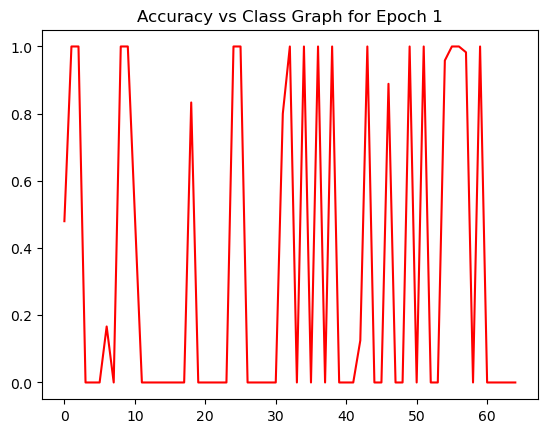

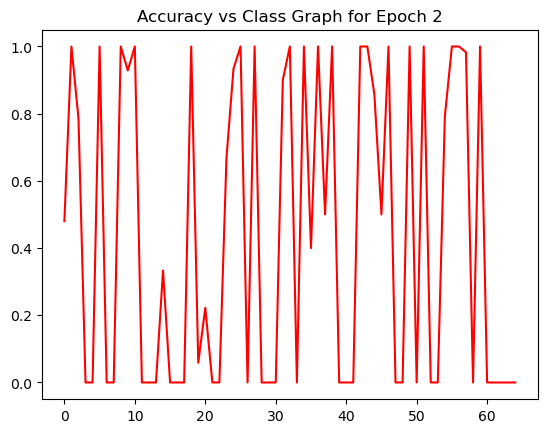

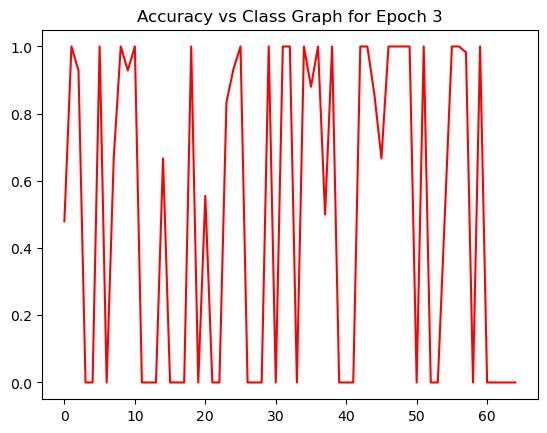

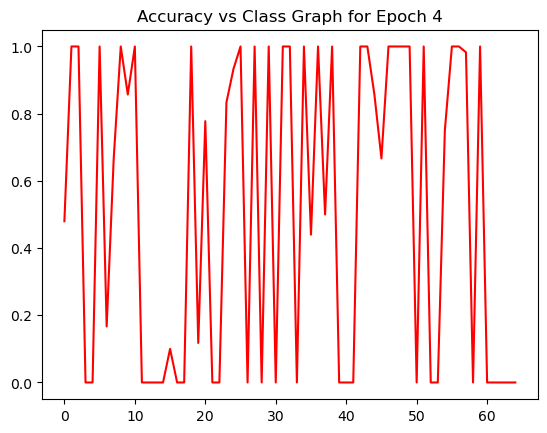

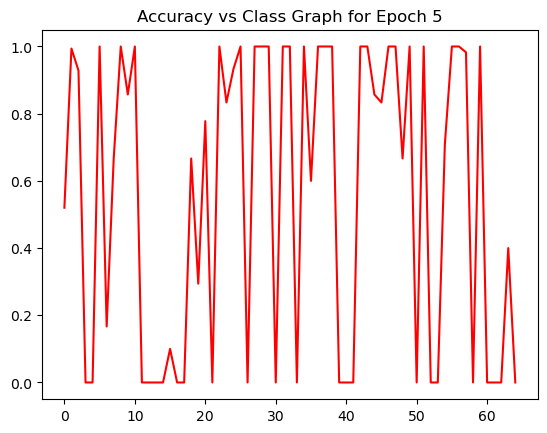

In [27]:
import accuracies2.epoch1 as e1
import accuracies2.epoch2 as e2
import accuracies2.epoch3 as e3
import accuracies2.epoch4 as e4
import accuracies2.epoch5 as e5
import matplotlib.pyplot as plt

def plot_accuracies(acc, title):
    plt.title(title)
    y = acc.values()
    plt.plot(y, color='red')
    plt.show()

plot_accuracies(e1.acc, "Accuracy vs Class Graph for Epoch 1")
plot_accuracies(e2.acc, "Accuracy vs Class Graph for Epoch 2")
plot_accuracies(e3.acc, "Accuracy vs Class Graph for Epoch 3")
plot_accuracies(e4.acc, "Accuracy vs Class Graph for Epoch 4")
plot_accuracies(e5.acc, "Accuracy vs Class Graph for Epoch 5")

In [24]:
# Create new dataset of project + project name and grant title
simple_df = clean_dataset
simple_df['project_profile'] =  simple_df['Applicants'] + ': ' + simple_df['Project Description'] + ' ' + simple_df['Project Name']
simple_df['grant_profile'] =  simple_df['opportunitytitle'] + ': ' + simple_df['description']
simple_df = simple_df[['project_profile','grant_profile'] ]
possible_grants = simple_df['grant_profile'].unique()

#substitute label with number instead
label_dict = {}
for index, possible_label in enumerate(possible_grants):
    label_dict[possible_label] = index

simple_df['label'] = simple_df['grant_profile'].replace(label_dict)
simple_df['grant_profile'].unique()[0]


<ipython-input-24-9fd1ad228c05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_df['project_profile'] =  simple_df['Applicants'] + ': ' + simple_df['Project Description'] + ' ' + simple_df['Project Name']
<ipython-input-24-9fd1ad228c05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_df['grant_profile'] =  simple_df['opportunitytitle'] + ': ' + simple_df['description']
<ipython-input-24-9fd1ad228c05>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

'FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of the In